In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import warnings

In [20]:
# Open data with wind
train = pd.read_csv('../../data/processed/train_with_wind.csv', sep=',')
test = pd.read_csv('../../data/processed/test_with_wind.csv', sep=',')

In [21]:
# Create dummy variables to recoginse the datasets
train['dataset'] = 'train'
test['dataset'] = 'test'

# Combine train and test based on the datetime column
data = pd.concat([train, test], axis=0)
data.sort_values('datetime', inplace=True)

#reset_index
data.reset_index(drop=True, inplace=True)

In [22]:
mask = data['dataset'] == 'train'

In [23]:
def smooth_data(data, features, window_sizes):
    """
    Smooths the specified features in the given data using rolling window averages.

    Args:
        data (pandas.DataFrame): The input data.
        features (list): A list of feature names to be smoothed.
        window_sizes (list): A list of window sizes for each feature.

    Returns:
        pandas.DataFrame: The data with smoothed features.

    """
    special = ['casual', 'registered', 'count']
    
    for i, feature in enumerate(features):
        # Calculate the minimum number of periods for the window
        min_periods = int(np.ceil(window_sizes[i]/2))
        if feature in special:
            data[feature + '_original'] = data[feature]
            data[feature] = data[feature].rolling(window=window_sizes[i], min_periods=min_periods, center=True).sum()
        else:
            data[feature] = data[feature].rolling(window=window_sizes[i], min_periods=min_periods, center=True).mean()
    return data

# Smooth data
features = ['temp', 'atemp', 'humidity', 'windspeed', 'count', 'registered', 'casual']
window_sizes = [3 for i in range(len(features))]
data = smooth_data(data, features, window_sizes)

ADF Statistic for count: -5.847278815025811
count is stationary



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


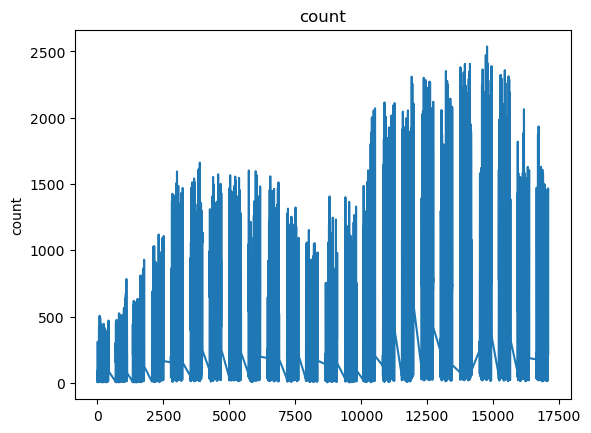

ADF Statistic for registered: -6.895758317684362
registered is stationary



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


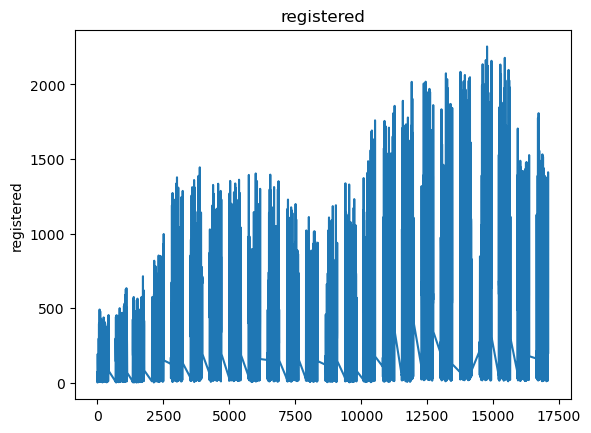

ADF Statistic for casual: -10.079809472798049
casual is stationary



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


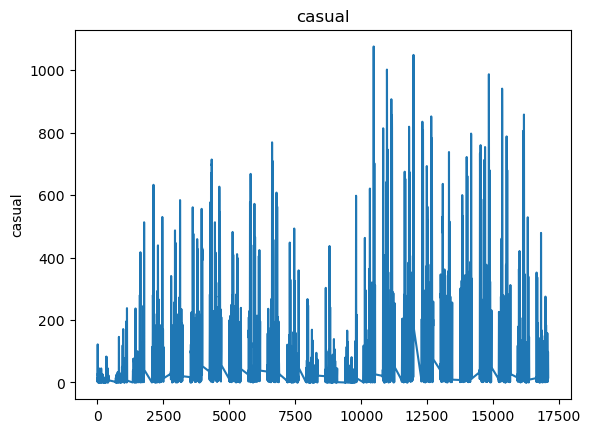

In [24]:
# check stationarity
from statsmodels.tsa.stattools import adfuller

def check_stationarity(dataset, columns):
    """
    Check the stationarity of the given columns in the dataset.

    Parameters:
    dataset (pandas.DataFrame): The dataset containing the columns to be checked.
    columns (list): A list of column names to be checked for stationarity.

    Returns:
    dict: A dictionary containing the results of the stationarity test for each column.
          The dictionary has the column names as keys and the test results as values.
          Each test result is a dictionary with the following keys:
          - 'ADF Statistic': The ADF statistic value.
          - 'p-value': The p-value of the test.
          - 'Critical Values': The critical values at different confidence levels.

    """
    stationary_results = {}
    
    for col in columns:
        result = adfuller(dataset[col])
        print(f'ADF Statistic for {col}: {result[0]}')
        stationary_results[col] = {'ADF Statistic': result[0],
                                   'p-value': result[1],
                                   'Critical Values': result[4]}
        # Print whether the data is stationary or not
        if result[1] < 0.05:
            print(f'{col} is stationary\n')
        else:
            print(f'{col} is not stationary\n')

        # Plot data with seaborn with index as x
        sns.lineplot(data=dataset, x=dataset.index, y=col)
        plt.title(col)
        plt.show()
        
    return stationary_results

# Check stationarity
columns = ['count', 'registered', 'casual']
stationarity_results = check_stationarity(data[mask], columns)


In [25]:
data.isnull().sum()

datetime                  0
season                    0
holiday                   0
workingday                0
weather                   0
temp                      0
atemp                     0
humidity                  0
windspeed                 0
casual                 6493
registered             6493
count                  6493
year                      0
month                     0
day                       0
hour                      0
dataset                   0
count_original         6493
registered_original    6493
casual_original        6493
dtype: int64

In [26]:
def remove_outliers(data, features):
    """
    Remove outliers from the given data based on the specified features.

    Parameters:
    data (pandas.DataFrame): The input data.
    features (list): A list of features to remove outliers from.

    Returns:
    pandas.DataFrame: The data with outliers removed.
    """

    # Create a new copied column for each feature
    for feature in features:
        data[f'{feature}_orig'] = data[feature].copy()

        # Calculate the z-score
        data[f'{feature}_zscore'] = np.abs((data[feature] - data[feature].mean())/data[feature].std())

        # Set to NaN values that are outliers
        data.loc[data[f'{feature}_zscore'] > 3, feature] = np.nan
        
    return data

# Remove outliers
features = ['count', 'registered', 'casual']
train = data[mask].copy()
data[mask] = remove_outliers(train, features)

In [27]:
def interpolate(data, features, limit_area=None):
    """
    Interpolates missing values in the specified features of the given data.

    Parameters:
    - data (pandas.DataFrame): The input data containing the features to be interpolated.
    - features (list): A list of feature names to be interpolated.
    - limit_area (str or None): Determines the area to limit the interpolation. 
      If None, the entire dataset is used. If 'inside', only the missing values inside the dataset are interpolated.
      If 'outside', only the missing values outside the dataset are interpolated.

    Returns:
    - pandas.DataFrame: The data with interpolated values in the specified features.
    """
    for feature in features:
        if limit_area is None:
            data[feature] = data[feature].interpolate(method='spline', order=3)
        else:
            data[feature] = data[feature].interpolate(method='spline', order=3, limit_area=limit_area)
    return data

# Interpolate outliers
train = data[mask].copy()
data[mask] = interpolate(train, features)

In [28]:
# convert datetime to datetime
data['datetime'] = pd.to_datetime(data['datetime'])

In [29]:
# Add day of the year number from 1 to 365
data['dayofyear'] = data['datetime'].dt.dayofyear

# Add week of the year number from 1 to 52
data['weekofyear'] = data['dayofyear'] // 7
# Add day of the week
data['dayofweek'] = data['datetime'].dt.dayofweek

In [30]:
data.isna().sum()

datetime                  0
season                    0
holiday                   0
workingday                0
weather                   0
temp                      0
atemp                     0
humidity                  0
windspeed                 0
casual                 6493
registered             6493
count                  6493
year                      0
month                     0
day                       0
hour                      0
dataset                   0
count_original         6493
registered_original    6493
casual_original        6493
dayofyear                 0
weekofyear                0
dayofweek                 0
dtype: int64

In [31]:
def create_lagged_features(df, features, lags, positive=True, negative=True):
    """
    Create lagged features for the given df and specified features.

    Args:
        df (pandas.dfFrame): The input df.
        features (list): List of column names to create lagged features for.
        lags (list): List of lag values (in days) to create features for.
        positive (bool, optional): Whether to create positive lagged features. Defaults to True.
        negative (bool, optional): Whether to create negative lagged features. Defaults to True.

    Returns:
        pandas.dfFrame: The df with lagged features added.
    """
    # Convert 'datetime' column to datetime type
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    for lag in lags:

        # Calculate positive and negative time offsets
        positive_time = df['datetime'] + pd.Timedelta(days=lag)
        negative_time = df['datetime'] + pd.Timedelta(days=-lag)

        # Create masks to filter df based on positive and negative time offsets
        positive_mask = positive_time.isin(df['datetime'])
        negative_mask = negative_time.isin(df['datetime'])

        # Create masks to filter df based on positive and negative dates
        positive_date_mask = df['datetime'].isin(positive_time)
        negative_date_mask = df['datetime'].isin(negative_time)
        
        for feature in features:
            current = df[feature]
            
            # Initialize lag arrays
            positive_lag = np.zeros(len(df))
            negative_lag = np.zeros(len(df))

            # Set NaN values for non-matching positive and negative time offsets
            positive_lag[~positive_mask] = np.nan
            negative_lag[~negative_mask] = np.nan

            # Assign lagged values based on positive and negative time offsets
            positive_lag[positive_mask] = current[positive_date_mask]
            negative_lag[negative_mask] = current[negative_date_mask]

            # Add lagged features to the df
            if positive:
                df[f'{feature}, +{lag}'] = positive_lag

            if negative:
                df[f'{feature}, -{lag}'] = negative_lag
    
    return df

# Create lagged features
features = ['windspeed', 'atemp', 'humidity', 'holiday', 'workingday', 'weather', 'temp', 'casual', 'registered', 'count']
days_of_lag = [1, 2]

lagged_data = create_lagged_features(data.copy(), features, days_of_lag)

In [32]:
lagged_data.isna().sum()

datetime             0
season               0
holiday              0
workingday           0
weather              0
                  ... 
casual, -2        6545
registered, +2    6596
registered, -2    6545
count, +2         6596
count, -2         6545
Length: 63, dtype: int64

In [33]:
def remove_missing_values(df, sample_columns):
    """
    Remove rows from a DataFrame that contain missing values in specified columns.

    Args:
        df (pandas.DataFrame): The DataFrame to remove missing values from.
        sample_columns (list): A list of column names to check for missing values.

    Returns:
        pandas.DataFrame: The DataFrame with rows containing missing values removed.
    """

    # find the first and last day of the dataset
    first_day = lagged_data['datetime'].min()
    last_day = lagged_data['datetime'].max()

    mask = np.zeros(len(lagged_data), dtype=bool)

    for col in sample_columns:
        if '+' in col:
            positive = True
            negative = False
        elif '-' in col:
            positive = False
            negative = True

        if '1' in col:
            days = 1
        elif '2' in col:
            days = 2
        
        if positive:
            min_day = first_day
            max_day = last_day - pd.Timedelta(days=days)
        elif negative:
            min_day = first_day + pd.Timedelta(days=days)
            max_day = last_day

        # mask the data which is internal to the dataset
        internal_mask = (lagged_data['datetime'] >= min_day) & (lagged_data['datetime'] <= max_day)

        # mask the rows which contain NaN values
        missing_value_mask = lagged_data[col].isna()

        total_mask = internal_mask & missing_value_mask
        mask = mask | total_mask

    print('Columns removed:', np.sum(mask))

    # remove the rows which contain NaN values
    df = df[~mask].copy()
    return df

# define sample columns
sample_columns = [col for col in lagged_data.columns if 'temp' in col and ('+' in col or '-' in col)]
print(sample_columns)

# drop the rows which contain NaN values
full_lagged_data = remove_missing_values(lagged_data, sample_columns)

['atemp, +1', 'atemp, -1', 'temp, +1', 'temp, -1', 'atemp, +2', 'atemp, -2', 'temp, +2', 'temp, -2']
Columns removed: 503


In [34]:
full_lagged_data.isna().sum()

datetime             0
season               0
holiday              0
workingday           0
weather              0
                  ... 
casual, -2        6172
registered, +2    6259
registered, -2    6172
count, +2         6259
count, -2         6172
Length: 63, dtype: int64

In [35]:
# round all columns that include holiday and workingday to 0 or 1
columns_to_round = [col for col in full_lagged_data.columns if 'holiday' in col or 'workingday' in col]

full_lagged_data[columns_to_round] = full_lagged_data[columns_to_round].round()

In [36]:
# save as final data
full_lagged_data.to_csv('../../data/processed/final_data.csv', index=False)